In [38]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from monai.utils import first, set_determinism
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import SimpleITK as sitk


In [39]:
output_folder = '/workspace/assignment/2024/0523_v.1/'


In [40]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# DATASET

In [41]:
clinical_pd = pd.read_csv('/workspace/DATA/UCSF-PDGM-v3/UCSF-PDGM-metadata_v2.csv')
values_to_remove = ['UCSF-PDGM-289', 'UCSF-PDGM-181', 'UCSF-PDGM-138', 'UCSF-PDGM-175', 'UCSF-PDGM-278', 'UCSF-PDGM-315','UCSF-PDGM-169']
clinical_pd = clinical_pd[~clinical_pd['ID'].isin(values_to_remove)]
clinical_pd = clinical_pd.reset_index(drop=True)
root_folder = '/workspace/DATA/UCSF-PDGM-v3/'

In [42]:
clinical_pd

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,UCSF-PDGM-537,M,64,4,"Glioblastoma, IDH-wildtype",positive,16.0,intact,wildtype,0,334.0,biopsy,Yes,NaN,NaN,NaN
490,UCSF-PDGM-538,F,41,4,"Glioblastoma, IDH-wildtype",negative,0.0,intact,wildtype,0,287.0,GTR,No,NaN,NaN,NaN
491,UCSF-PDGM-539,M,72,4,"Glioblastoma, IDH-wildtype",positive,12.0,intact,wildtype,0,291.0,GTR,No,NaN,NaN,NaN
492,UCSF-PDGM-540,F,70,2,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",positive,17.0,Co-deletion,IDH1 p.R132H,0,215.0,STR,No,NaN,NaN,NaN


In [43]:
#clinical data Sex M=0, F=1
#change clinical_pd['Sex'] to 0, 1
clinical_pd['Sex'] = clinical_pd['Sex'].replace({'M': 0, 'F': 1})
clinical_pd

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,0,66,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,1,80,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,0,70,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,0,70,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,1,68,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,UCSF-PDGM-537,0,64,4,"Glioblastoma, IDH-wildtype",positive,16.0,intact,wildtype,0,334.0,biopsy,Yes,NaN,NaN,NaN
490,UCSF-PDGM-538,1,41,4,"Glioblastoma, IDH-wildtype",negative,0.0,intact,wildtype,0,287.0,GTR,No,NaN,NaN,NaN
491,UCSF-PDGM-539,0,72,4,"Glioblastoma, IDH-wildtype",positive,12.0,intact,wildtype,0,291.0,GTR,No,NaN,NaN,NaN
492,UCSF-PDGM-540,1,70,2,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",positive,17.0,Co-deletion,IDH1 p.R132H,0,215.0,STR,No,NaN,NaN,NaN


In [44]:
from sklearn.model_selection import train_test_split
#495명
# clinical_pd 데이터프레임을 train, valid, test로 나누기
# train_valid, test_pd = train_test_split(clinical_pd, test_size=0.2, stratify = clinical_pd['1-dead 0-alive'],random_state=42)
train_pd, valid_pd = train_test_split(clinical_pd, test_size=0.3,stratify = clinical_pd['1-dead 0-alive'], random_state=31)  # 0.25 x 0.8 = 0.2

# 인덱스 리셋
train_pd.reset_index(drop=True, inplace=True)
valid_pd.reset_index(drop=True, inplace=True)
# test_pd.reset_index(drop=True, inplace=True)


In [45]:
valid_pd

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-144,0,57,4,"Glioblastoma, IDH-wildtype",positive,15.0,intact,wildtype,1,142.0,STR,No,BraTS2021_00559,Training,Training
1,UCSF-PDGM-387,1,68,4,"Glioblastoma, IDH-wildtype",positive,11.0,intact,wildtype,0,86.0,biopsy,No,BraTS2021_00737,Training,Training
2,UCSF-PDGM-011,1,68,4,"Glioblastoma, IDH-wildtype",positive,5.0,NaN,wildtype,0,133.0,STR,No,BraTS2021_00068,Training,Training
3,UCSF-PDGM-265,1,44,2,"Oligodendroglioma, IDH-mutant, 1p/19q-codeleted",NaN,NaN,co-deletion,mutated (NOS),0,916.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-420,1,57,4,"Glioblastoma, IDH-wildtype",positive,16.0,intact,wildtype,0,213.0,GTR,No,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,UCSF-PDGM-438,1,38,2,"Astrocytoma, IDH-mutant",NaN,NaN,intact,IDH1 p.R132C,0,1280.0,STR,No,NaN,NaN,NaN
145,UCSF-PDGM-290,0,43,4,"Astrocytoma, IDH-mutant",positive,4.0,intact,IDH1 p.R132H,0,407.0,GTR,No,BraTS2021_00768,Training,Training
146,UCSF-PDGM-336,0,57,4,"Glioblastoma, IDH-wildtype",NaN,NaN,intact,wildtype,1,177.0,GTR,No,BraTS2021_01156,Training,NaN
147,UCSF-PDGM-035,0,69,4,"Glioblastoma, IDH-wildtype",positive,2.0,NaN,wildtype,1,132.0,STR,No,NaN,NaN,NaN


In [46]:
# print(train_pd.shape, valid_pd.shape, test_pd.shape)
print(train_pd.shape, valid_pd.shape)


(345, 16) (149, 16)


In [47]:

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Resized,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    # SpatialCropd,
    SpatialCrop
)

from monai.config import print_config
from monai.metrics import DiceMetric

In [48]:
from monai.transforms.compose import Transform, MapTransform

class MinMax(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] -= np.min(d[key])
            d[key] /= np.max(d[key])
        return d

In [49]:
num_samples = 1
IMAGE_SIZE = (128,128,64) #original 240 240 155

train_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(IMAGE_SIZE), mode=['trilinear']),
        MinMax(keys=['image']),
        Orientationd(keys=["image"], axcodes="RAS"), #RAS(Right-Anterior-Superior)로 조정
        EnsureTyped(keys=["image"], device=device, track_meta=False), #데이터 타입 확인
        RandFlipd(
            keys=["image"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandShiftIntensityd( #이미지 intensity 10%
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        Resized(keys=["image"], spatial_size=(IMAGE_SIZE), mode=['trilinear']),
        MinMax(keys=['image']),
        Orientationd(keys=["image"], axcodes="RAS"),
        EnsureTyped(keys=["image"], device=device, track_meta=True),
    ]
)

In [50]:
#Dataset
#load pandas dataframe and images

class Dataset(Dataset):
    def __init__(self, pd, root_dir, transform=None):
        self.pd = pd
        self.root_dir = root_dir
        self.transform = transform
        # self.target_size = target_size
        
        
    def __len__(self):
        return len(self.pd)
    def __getitem__(self, idx):
        # print(self.pd.iloc[idx, 'PatientID'])
        patient_id = self.pd.iloc[0, self.pd.columns.get_loc('ID')] #ucsf-pdgm-001
        #change patient id : ucsf-pdgm-001 to ucsf-pdgm-0001
        # patient_id에서 숫자 부분만 추출하여 새로운 형식으로 포맷
        patient_id = 'UCSF-PDGM-' + f"{int(self.pd.iloc[0, self.pd.columns.get_loc('ID')].split('-')[-1]):04d}"

        img_name = os.path.join(self.root_dir, patient_id+'_nifti', patient_id+'_FLAIR_bias.nii.gz')
        # print(img_name)
        # roi_img_name = os.path.join(self.root_dir, patient_id+'_nifti', patient_id+'_tumor_segmentation_binary.nii.gz')
        age = self.pd.iloc[idx, self.pd.columns.get_loc('Age at MRI')]
        sex = self.pd.iloc[idx, self.pd.columns.get_loc('Sex')]
        #concat age, sex to feature
        features = np.array([age,sex])
        seed = 42 + idx
    
        output = {'image': img_name, 'clinical_features': features, 'event': self.pd.iloc[idx, self.pd.columns.get_loc('1-dead 0-alive')] ,'time' : self.pd.iloc[idx, self.pd.columns.get_loc('OS')]}
        if self.transform:
                torch.manual_seed(seed)
                # image = self.resize_image(image)
                output = self.transform(output)
                # torch.manual_seed(seed)
            
        return output 


In [51]:
valid_dataset = Dataset(valid_pd, root_folder, transform=val_transforms)
valid_dataset[3]

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

In [52]:
# from matplotlib import image


# valid_dataset = Dataset(valid_pd, root_folder, transform=val_transforms)
# test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)


# for i, data in enumerate(test_loader, 0):
#     inputs, labels= data['image'], data['label']
#     input_image = sitk.GetImageFromArray(inputs.cpu().squeeze().numpy())
#     label_image = sitk.GetImageFromArray(labels.cpu().squeeze().numpy())
#     print(inputs.shape)
#     print(sitk.GetArrayFromImage(input_image).shape)
#     sitk.WriteImage(input_image, output_folder+f'input_image_{i}.nii.gz')
#     sitk.WriteImage(label_image, output_folder+f'label_image_{i}.nii.gz')
#     break
    
        

In [53]:
# import nibabel as nib

# for i, data in enumerate(test_loader, 0):
#     inputs, labels = data['image'], data['label']
    
#     # numpy 배열로 변환
#     input_array = inputs.cpu().squeeze().numpy()
#     label_array = labels.cpu().squeeze().numpy()
    
#     # NIfTI 이미지 생성
#     input_nifti = nib.Nifti1Image(input_array, affine=np.eye(4))
#     label_nifti = nib.Nifti1Image(label_array, affine=np.eye(4))
    
#     # 디버깅용 출력
#     print(inputs.shape)
#     print(input_array.shape)
    
#     # 이미지 저장
#     nib.save(input_nifti, output_folder + f'nib_input_image_{i}.nii.gz')
#     nib.save(label_nifti, output_folder + f'nib_label_image_{i}.nii.gz')
    
#     break  # 첫 번째 배치만 처리


# UNET

https://github.com/lee-zq/3DUNet-Pytorch/tree/master/models

In [54]:
"""
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
Paper URL: https://arxiv.org/abs/1606.06650
Author: Amir Aghdam
"""

from torch import nn
# from torchsummary import summary
import torch
import time



class Conv3DBlock(nn.Module):
    """
    The basic block for double 3x3x3 convolutions in the analysis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> desired number of output channels
    :param bottleneck -> specifies the bottlneck block
    -- forward()
    :param input -> input Tensor to be convolved
    :return -> Tensor
    """

    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res




class UpConv3DBlock(nn.Module):
    """
    The basic block for upsampling followed by double 3x3x3 convolutions in the synthesis path
    -- __init__()
    :param in_channels -> number of input channels
    :param out_channels -> number of residual connections' channels to be concatenated
    :param last_layer -> specifies the last output layer
    :param num_classes -> specifies the number of output channels for dispirate classes
    -- forward()
    :param input -> input Tensor
    :param residual -> residual connection to be concatenated with input
    :return -> Tensor
    """

    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and num_classes==None) or (last_layer==True and num_classes!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=num_classes, kernel_size=(1,1,1))
            
        
    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual!=None: out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer: out = self.conv3(out)
        return out
        
class surv_mlp(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super(surv_mlp, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, input):
        out = self.relu(self.fc1(input))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        return out

    
 

class UNet3D(nn.Module):
    """
    The 3D UNet model
    -- __init__()
    :param in_channels -> number of input channels
    :param num_classes -> specifies the number of output channels or masks for different classes
    :param level_channels -> the number of channels at each level (count top-down)
    :param bottleneck_channel -> the number of bottleneck channels 
    :param device -> the device on which to run the model
    -- forward()
    :param input -> input Tensor
    :return -> Tensor
    """
    
    def __init__(self, in_channels, num_classes, level_channels=[64, 128, 256], bottleneck_channel=512) -> None:
        super(UNet3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls = level_channels[0], level_channels[1], level_channels[2]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=level_3_chnls, out_channels=bottleneck_channel, bottleneck= True)
        #
        self.bottleNeck2 = Conv3DBlock(in_channels=bottleneck_channel, out_channels=bottleneck_channel)
        self.bottleNeck3 = Conv3DBlock(in_channels=bottleneck_channel, out_channels=bottleneck_channel)
        self.bottleNeck4 = Conv3DBlock(in_channels=bottleneck_channel, out_channels=bottleneck_channel)
        self.surv_mlp = surv_mlp(2050,1)

    
    def forward(self, input, clinical_features):
        #Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)
        surv_out, _ = self.bottleNeck2(out) #torch.Size([2, 512, 8, 8, 4]) torch.Size([2, 512, 16, 16, 8])
        surv_out2,_ = self.bottleNeck3(surv_out) #torch.Size([2, 512, 4, 4, 2]) torch.Size([2, 512, 8, 8, 4])
        surv_out3,_ = self.bottleNeck4(surv_out2) #torch.Size([2, 512, 2, 2, 1]) torch.Size([2, 512, 4, 4, 2])
        surv_out3 = surv_out3.squeeze(-1) #torch.Size([2, 512, 2, 2])
        surv_out3 = surv_out3.reshape(surv_out3.size(0), -1) #torch.Size([2, 2048])
        surv_out3 = torch.cat((surv_out3,clinical_features),1)
        risk_score = self.surv_mlp(surv_out3)

        return risk_score


In [55]:
input_size =(2,1, 128, 128, 64)  # Example: (batch, channels, depth, height, width)
clinical = (2,2)
model = UNet3D(in_channels=1, num_classes=1)
x = torch.rand(input_size)
y=  torch.rand(clinical)
# grade_score, risk_score = model(x,y)
risk_score = model(x,y)

print(f"Input size: {input_size}")
print(f"Output size: {risk_score.size()}")
# print(f"risk_score size: {risk_score.size()}")
print(risk_score)


Input size: (2, 1, 128, 128, 64)
Output size: torch.Size([2, 1])
tensor([[ 0.3589],
        [-0.0310]], grad_fn=<AddmmBackward0>)


In [56]:
class NegativeLogLikelihood(nn.Module): #낮을 수록 좋은것. 
    def __init__(self, l2_reg=None):
        super().__init__()
        if l2_reg is not None:
            self.is_reg = True
            self.reg = Regularization(order=2, weight_decay=l2_reg)
        else:
            self.is_reg = False

    def forward(self, risk_pred, censor, y, device, model):
        # e = 1.-censor
        e = censor
        mask = torch.ones(y.shape[0], y.shape[0]).to(device, dtype=torch.float)
        mask[(y.T - y) > 0] = 0
        log_loss = torch.exp(risk_pred) * mask
        log_loss = torch.sum(log_loss, dim=0) / torch.sum(mask, dim=0)
        log_loss = torch.log(log_loss).reshape(-1, 1)
        neg_log_loss = -torch.sum((risk_pred-log_loss) * e)
        neg_log_loss = neg_log_loss / (torch.sum(e) + 1e-6)
        if self.is_reg:
            l2_loss = self.reg(model)
            neg_log_loss = neg_log_loss + l2_loss
        return neg_log_loss
    
    
class Regularization(object):
    def __init__(self, order, weight_decay):
        ''' The initialization of Regularization class
        :param order: (int) norm order number
        :param weight_decay: (float) weight decay rate
        '''
        super(Regularization, self).__init__()
        self.order = order
        self.weight_decay = weight_decay

    def __call__(self, model):
        ''' Performs calculates regularization(self.order) loss for model.
        :param model: (torch.nn.Module object)
        :return reg_loss: (torch.Tensor) the regularization(self.order) loss
        '''
        reg_loss = 0
        for name, w in model.named_parameters():
            #if 'weight' in name:
            reg_loss = reg_loss + torch.norm(w, p=self.order)
        reg_loss = self.weight_decay * reg_loss
        return reg_loss


# TRAIN

In [57]:
from lifelines.utils import concordance_index
from datetime import datetime
from monai.data import DataLoader, pad_list_data_collate
from lifelines.statistics import logrank_test
from monai.metrics import DiceMetric
from torch.nn.utils import clip_grad_norm_

In [58]:
import monai
model = UNet3D(in_channels=1, num_classes=1)
criterion= NegativeLogLikelihood().to(device)  # For risk score

model.to(device)


UNet3D(
  (a_block1): Conv3DBlock(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a_block2): Conv3DBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, 

In [63]:
from numpy import test
from lifelines.utils import concordance_index
from datetime import datetime
from monai.data import DataLoader, pad_list_data_collate
from lifelines.statistics import logrank_test
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score
from lifelines import KaplanMeierFitter


optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 전체 모델 파라미터

def train(device):
    torch.autograd.set_detect_anomaly(True)
    num_epochs = 100
    best_model_result=0.5
    start_time = datetime.now()
    train_dataset = Dataset(valid_pd, root_folder, transform=train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    valid_dataset = Dataset(valid_pd, root_folder, transform=val_transforms)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    train_loss_list = [0] * num_epochs
    test_loss_list = [0] * num_epochs
    c_index_train_list = [0] * num_epochs
    c_index_test_list = [0] * num_epochs
    p_value_train_list = [0] * num_epochs
    p_value_test_list = [0] * num_epochs
    best_model_epoch=[]
    median_risk_list= [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_seg_loss = 0.0
        train_surv_loss = 0.0
        surv_y_true =[]
        surv_y_pred = []
        event_list=[]
        for  data in train_loader:
            inputs, clinical_features, event, time = data['image'], data['clinical_features'], data['event'], data['time']
            inputs, clinical_features= inputs.to(device), clinical_features.to(device)
            event, time = event.to(device), time.to(device)
            event = event.reshape(-1,1)
            time = time.reshape(-1,1)
            optimizer.zero_grad()
            risk_score = model(inputs, clinical_features)
            risk_score = risk_score.reshape(-1,1)
            # loss = criterion()
            loss = criterion(risk_score, event, time, device, model)
            loss.backward()
            clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            train_loss += loss.item()
            surv_y_true.extend(time.cpu().numpy())
            event_list.extend(event.cpu().numpy())
            surv_y_pred.extend(risk_score.cpu().detach().numpy())
        try:
            train_c_index = concordance_index(surv_y_true, -np.array(surv_y_pred), event_list) 
        except ValueError as e:
            print("NaN values detected. Skipping calculation of concordance index.")
            train_c_index=0
            # break
        except ZeroDivisionError:
            train_c_index=0
        event_list = [int(arr[0]) for arr in event_list]
        surv_y_true =[float(arr[0]) for arr in surv_y_true]
        y_pred =[float(arr[0]) for arr in surv_y_pred]
        train_df = pd.DataFrame({'risk_score':y_pred,'time':surv_y_true,'event':event_list})
        df_sorted = train_df.sort_values(by='risk_score')
        half = len(df_sorted) // 2
        df_1 = df_sorted.iloc[:half]
        df_2 = df_sorted.iloc[half:]
        median_risk = df_sorted.iloc[half]['risk_score']
        print(f"median risk: {median_risk}")
        train_log = logrank_test(df_1['time'],df_2['time'], df_1['event'], df_2['event'])
        train_loss = train_loss/len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, C-index: {train_c_index}, pvalue :{train_log.p_value:.3f}")
        with torch.no_grad():
            model.eval()
            valid_loss =0.0
            surv_y_true =[]
            surv_y_pred = []
            event_list =[]
            for data in valid_loader:
                inputs, clinical_features, event, time = data['image'], data['clinical_features'], data['event'], data['time']
                inputs, clinical_features= inputs.to(device), clinical_features.to(device)
                event, time = event.to(device), time.to(device)
                risk_score = model(inputs, clinical_features)
                risk_score = risk_score.reshape(-1,1)
                event = event.reshape(-1,1)
                time = time.reshape(-1,1)
                loss = criterion(risk_score, event, time, device, model)
                valid_loss += loss.item()
                surv_y_true.extend(time.cpu().numpy())
                event_list.extend(event.cpu().numpy())
                surv_y_pred.extend(risk_score.cpu().detach().numpy())
            valid_loss = valid_loss/len(valid_loader)
            try:
                valid_c_index = concordance_index(surv_y_true, -np.array(surv_y_pred), event_list) 
            except ValueError as e:
                print("NaN values detected. Skipping calculation of concordance index.")
                valid_c_index=0
                # break
            except ZeroDivisionError:
                valid_c_index=0
            event_list = [int(arr[0]) for arr in event_list]
            surv_y_true =[float(arr[0]) for arr in surv_y_true]
            y_pred =[float(arr[0]) for arr in surv_y_pred]
            valid_df = pd.DataFrame({'risk_score':y_pred,'time':surv_y_true,'event':event_list})
            df_sorted = valid_df.sort_values(by='risk_score')
            df_1 = df_sorted[df_sorted['risk_score'] < median_risk]
            df_2 = df_sorted[df_sorted['risk_score'] >= median_risk]
            test_log = logrank_test(df_1['time'],df_2['time'], df_1['event'], df_2['event'])
            print(f"Valid Epoch {epoch+1}/{num_epochs}, Loss: {valid_loss}, C-index: {valid_c_index} , pvalue :{test_log.p_value:.3f}")         
        train_loss_list[epoch]= train_loss
        test_loss_list[epoch] = valid_loss
        c_index_train_list[epoch]=train_c_index
        c_index_test_list[epoch]=valid_c_index
        median_risk_list[epoch]=median_risk
        p_value_train_list[epoch]=train_log.p_value
        p_value_test_list[epoch]=test_log.p_value
        torch.save(model.state_dict(),f'{output_folder}model_{epoch}.pth')
        # print(f"Training time: {datetime.now()-start_time}")
        # print()
        if valid_c_index > 0.5 and test_log.p_value <0.05 and train_c_index>0.5 and train_log.p_value <0.05:
            # best_model_result = valid_c_index
            kmf = KaplanMeierFitter(alpha = 0.05)
            kmf.fit(df_1['time'], df_1['event'], label='Low risk group')
            kmf.plot()
            kmf.fit(df_2['time'], df_2['event'], label='High risk group')
            kmf.plot()        
            plt.xlabel('time')
            plt.ylabel('surv prop')
            plt.show()
            print(f"Best Model saved at epoch {epoch}, {train_c_index},{train_log.p_value:.3f}")
    print(f"Training time: {datetime.now()-start_time}")

    return train_loss_list,test_loss_list, c_index_train_list, c_index_test_list, median_risk_list, p_value_train_list, p_value_test_list

        

median risk: 1.6148545742034912
Epoch 1/100, Loss: 6.000461872346151e-10, C-index: 0.524966261808367, pvalue :0.623
Valid Epoch 1/100, Loss: 0.0, C-index: 0.7193825910931174 , pvalue :nan
median risk: 1.3407442569732666
Epoch 2/100, Loss: 3.7502886702163445e-09, C-index: 0.6384952766531714, pvalue :0.000
Valid Epoch 2/100, Loss: 6.000461872346151e-09, C-index: 0.7166835357624831 , pvalue :nan
median risk: 0.3793982267379761
Epoch 3/100, Loss: 4.562851227351743e-09, C-index: 0.5681511470985156, pvalue :0.503
Valid Epoch 3/100, Loss: 1.7601354825548708e-08, C-index: 0.7166835357624831 , pvalue :nan
median risk: 1.1874183416366577
Epoch 4/100, Loss: 2.915849444073672e-09, C-index: 0.5814777327935222, pvalue :0.032
Valid Epoch 4/100, Loss: 2.3001770510660246e-09, C-index: 0.7198886639676113 , pvalue :nan
median risk: 0.9198454022407532
Epoch 5/100, Loss: 4.025309863209259e-09, C-index: 0.5416666666666666, pvalue :0.187
Valid Epoch 5/100, Loss: 7.200554246815381e-09, C-index: 0.716683535762

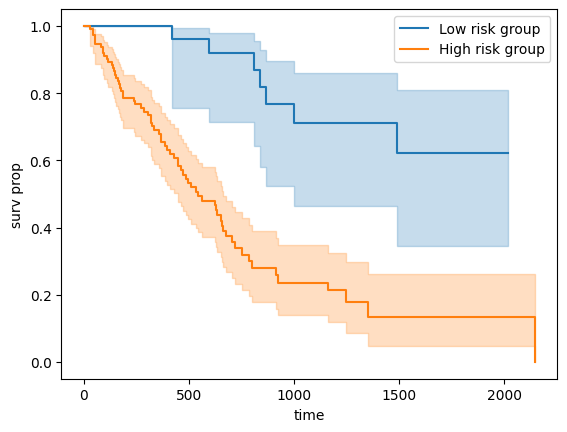

Best Model saved at epoch 7, 0.5654520917678812,0.029
median risk: 1.3187215328216553
Epoch 9/100, Loss: 6.981006078951896e-10, C-index: 0.5077597840755735, pvalue :0.239
Valid Epoch 9/100, Loss: 4.000307914897434e-10, C-index: 0.7166835357624831 , pvalue :nan
median risk: 0.942313551902771
Epoch 10/100, Loss: 3.875298292556889e-09, C-index: 0.5553306342780027, pvalue :0.034
Valid Epoch 10/100, Loss: -8.000615829794868e-10, C-index: 0.7170209176788124 , pvalue :nan
median risk: 1.4861347675323486
Epoch 11/100, Loss: 5.025386841933617e-09, C-index: 0.5512820512820513, pvalue :0.352
Valid Epoch 11/100, Loss: 0.0, C-index: 0.7166835357624831 , pvalue :nan
median risk: 3.443140983581543
Epoch 12/100, Loss: 1.6001231659589736e-09, C-index: 0.564608636977058, pvalue :0.250
Valid Epoch 12/100, Loss: 1.6001231659589736e-09, C-index: 0.7166835357624831 , pvalue :0.000
median risk: 4.10730504989624
Epoch 13/100, Loss: -8.000615829794868e-10, C-index: 0.5914304993252362, pvalue :0.044
Valid Epoch

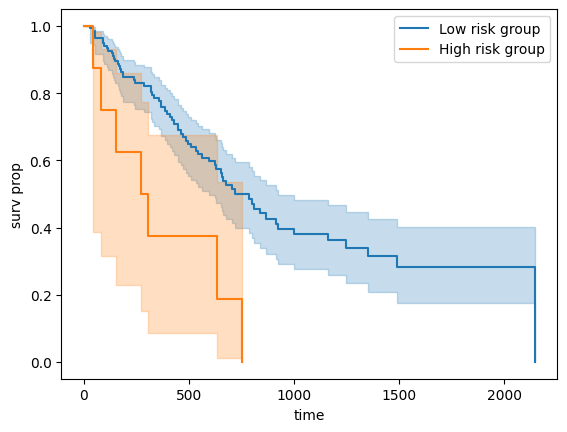

Best Model saved at epoch 28, 0.583502024291498,0.005
median risk: 2.490229368209839
Epoch 30/100, Loss: 2.600200144683332e-09, C-index: 0.5942982456140351, pvalue :0.212


In [64]:
train_loss_list,test_loss_list, c_index_train_list, c_index_test_list, median_risk_list, p_value_train_list, p_value_test_list= train(device)
def save_list_to_txt(lst, filename):
    with open(filename, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')

# 리스트를 txt 파일로 저장
save_list_to_txt(train_loss_list, output_folder+'train_loss.txt')
save_list_to_txt(test_loss_list, output_folder+'valid_loss.txt')
save_list_to_txt(c_index_train_list, output_folder+'c_index_train.txt')
save_list_to_txt(c_index_test_list, output_folder+'c_index_test.txt')
save_list_to_txt(median_risk_list, output_folder+'median_risk.txt')
save_list_to_txt(p_value_train_list, output_folder+'p_value_train.txt')
save_list_to_txt(p_value_test_list, output_folder+'p_value_test.txt')
